# GeoPandas Gridding Example

*Rob Knapen, Wageningen Environmental Research*
<br>

A notebook for trying out [GeoPandas](https://geopandas.org/) for gridding species observations.

In this notebook species observation data from NDFF is used. For more information about this data please contact NDFF or visit their website (be aware that it is not fully available in English).

**Data source(s)**:
- ['Nationale Databank Flora en Fauna'](https://ndff.nl) (October 2022). This data is copy protected.

### Import Python Packages

In [41]:
import os

import matplotlib.pyplot as plt

# note that GeoPandas is switching from PyGEOS geometry backend to Shapely 2.0
os.environ['USE_PYGEOS'] = '0'

import pandas as pd
import numpy as np
import geopandas as gp

import shapely

from geocube.api.core import make_geocube

### Load sample species observation data
As an example a dataset from the Dutch ['Nationale Databank Flora en Fauna'](https://ndff.nl). While we are hoping for this to be available as open data (soon), it is not yet. However, we have permission to use it for the FAIRiCUBE EU project.

In [42]:
# the NDFF datafile to process
#
# Available datasets:
# broedvogels_2016.csv      (observations of nesting birds in 2016)     drop = None
# overigesoorten_2016.csv   (observations of 'other' species in 2016)   drop = ['obs_uri']
# planten_2016.csv          (observations of plants in 2016)            drop = ['obs_uri']
#
obs_filename = "../../../local/data/ndff/overigesoorten_2016.csv"
obs_crs = "EPSG:28992"

# the columns to drop right away
#always_drop_cols_from_source = None
always_drop_cols_from_source = ['obs_uri']

# area of interest
aoi_crs  = 'EPSG:32631' # WGS 84 / UTM zone 31N
aoi_xmin =  674900.0
aoi_xmax =  729800.0
aoi_ymin = 5832230.0
aoi_ymax = 5853960.0

# base output path prefix, used for created files
out_prefix = "../data/processed/otherspecies_2016_"

### Use a Pandas DataFrame for some pre-processing
Do some initial cleaning of the data first. Also fix the geometry data, so it fits GeoPandas expectations.

It would be worthwhile to save the pre-processed data for reuse later. We can then directly specify filter criteria, including a bounding box filter, when reading the data.

In [43]:
# load the data into a regular pandas dataframe
obs_df = pd.read_csv(obs_filename, header='infer', sep=';', on_bad_lines='warn')

# remove not needed columns
if always_drop_cols_from_source:
    obs_df.drop(columns=always_drop_cols_from_source, inplace=True)

# remove the crs prefix from the wkt data
obs_df['wkt_excl_crs'] = obs_df['wkt'].map(lambda x: x.split(';')[1], na_action='ignore')
obs_df.drop(columns=['wkt'], inplace=True)
obs_df.rename(columns={'wkt_excl_crs': 'wkt'}, inplace=True)

# remove non-numeric abundance values
obs_df = obs_df[pd.to_numeric(obs_df['orig_abundance'], errors='coerce').notnull()]
obs_df['orig_abundance'] = obs_df['orig_abundance'].astype(float)

obs_df.head(5)

,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,wkt
0,Paardenbijter,Aeshna mixta,2016,levend exemplaar,3.0,71,"POLYGON((201846.994196555 387310.325765192,201..."
1,Gewone oeverlibel,Orthetrum cancellatum,2016,levend exemplaar,3.0,283,"POLYGON((91136.4726110989 443044.194701222,911..."
2,Citroenvlinder,Gonepteryx rhamni,2016,levend exemplaar,1.0,71,"POLYGON((152931.103142183 445506.187935355,152..."
3,Icarusblauwtje,Polyommatus icarus,2016,levend exemplaar,1.0,71,"POLYGON((68831.2757593919 444283.292744242,688..."
4,Boomblauwtje,Celastrina argiolus,2016,levend exemplaar,1.0,71,"POLYGON((180015.605299007 366408.956150623,180..."


### Lift the data into a GeoPandas GeoDataFrame
Create a GeoPandas GeoDataFrame from the regular (non spatial-aware) DataFrame. After that use GeoPandas functionality to transform the data from the Dutch coordinate reference system to the preferred CRS for the area of interest.

In [44]:
# note that we used the pandas dataframe
obs_gs = gp.GeoSeries.from_wkt(obs_df['wkt'])
obs_gdf = gp.GeoDataFrame(obs_df, geometry=obs_gs, crs=obs_crs)

# transform the dataset to the CRS of the area of interest
obs_gdf.to_crs(crs=aoi_crs, inplace=True)
obs_gdf.drop(columns=['wkt'], inplace=True)

obs_gdf.head(5)

,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,geometry
0,Paardenbijter,Aeshna mixta,2016,levend exemplaar,3.0,71,"POLYGON ((712609.052 5706860.722, 712607.882 5..."
1,Gewone oeverlibel,Orthetrum cancellatum,2016,levend exemplaar,3.0,283,"POLYGON ((600137.172 5758942.850, 600134.243 5..."
2,Citroenvlinder,Gonepteryx rhamni,2016,levend exemplaar,1.0,71,"POLYGON ((661811.071 5763431.713, 661809.606 5..."
3,Icarusblauwtje,Polyommatus icarus,2016,levend exemplaar,1.0,71,"POLYGON ((577808.903 5759448.804, 577807.438 5..."
4,Boomblauwtje,Celastrina argiolus,2016,levend exemplaar,1.0,71,"POLYGON ((691466.031 5685257.491, 691464.566 5..."


In [45]:
# save this data in a GIS format
obs_gdf.to_file(out_prefix + "nl_cleaned.gpkg", driver="GPKG")

### Data selection

In [46]:
# only execute this cell when you want to change the aoi to the full dataset!
#aoi_xmin = obs_gdf.total_bounds[0]
#aoi_ymin = obs_gdf.total_bounds[1]
#aoi_xmax = obs_gdf.total_bounds[2]
#aoi_ymax = obs_gdf.total_bounds[3]

In [47]:
# spatially select observations within the area of interest
aoi_obs_gdf = obs_gdf.cx[aoi_xmin:aoi_xmax, aoi_ymin:aoi_ymax]
aoi_obs_gdf.head(5)

,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,geometry
22,Koevinkje,Aphantopus hyperantus,2016,levend exemplaar,1.0,102,"POLYGON ((691027.977 5851898.069, 691026.219 5..."
23,Atalanta,Vanessa atalanta,2016,levend exemplaar,1.0,283,"POLYGON ((691576.434 5851618.552, 691573.505 5..."
24,Bruin zandoogje,Maniola jurtina,2016,levend exemplaar,1.0,283,"POLYGON ((691150.684 5851803.096, 691147.755 5..."
25,Klein geaderd witje,Pieris napi,2016,levend exemplaar,1.0,283,"POLYGON ((691696.443 5851299.244, 691693.514 5..."
26,Dagpauwoog,Aglais io,2016,levend exemplaar,1.0,283,"POLYGON ((691495.158 5851482.848, 691492.229 5..."


In [48]:
# save this data in a GIS format for reuse
aoi_obs_gdf.to_file(out_prefix + "aoi_cleaned.gpkg", driver="GPKG")

### Extend observation polygons with indicated radius

For each observation create a buffer with the recorded radius around the recorded geometry.

In [49]:
aoi_obs_buff_gdf = aoi_obs_gdf.copy()

# add the buffers
aoi_obs_buff_gdf['geometry'] = aoi_obs_gdf.apply(lambda row:
                                                 (row['geometry'].buffer(row['straal'])),
                                                 axis=1)
# add the area of the buffers
aoi_obs_buff_gdf['area_buff'] = aoi_obs_buff_gdf.area

aoi_obs_buff_gdf.head(3)

/Users/robknapen/opt/mambaforge/envs/fairicube-pt2/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,geometry,area_buff
22,Koevinkje,Aphantopus hyperantus,2016,levend exemplaar,1.0,102,"POLYGON ((691122.212 5851937.103, 691125.584 5...",36481.710013
23,Atalanta,Vanessa atalanta,2016,levend exemplaar,1.0,283,"POLYGON ((691837.892 5851726.852, 691847.248 5...",268813.780457
24,Bruin zandoogje,Maniola jurtina,2016,levend exemplaar,1.0,283,"POLYGON ((691412.142 5851911.396, 691421.498 5...",268813.780455


<Axes: >

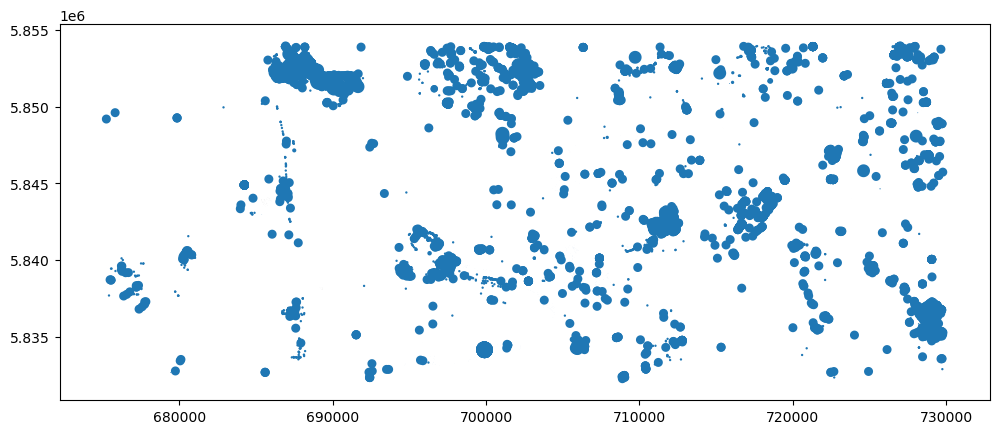

In [50]:
aoi_obs_buff_gdf.plot(figsize=(12, 8))

In [51]:
# save this data in a GIS format for reuse
aoi_obs_buff_gdf.to_file(out_prefix + "aoi_cleaned_buffered.gpkg", driver="GPKG")

### Create a GeoDataFrame with a grid
Construct a grid that covers the extent of the area of interest. This will later be used to aggregate the data into.

__TODO: Create the grid based on the requested CRS for the area of interest.__


In [52]:
# total area for the grid
xmin, ymin, xmax, ymax= aoi_obs_gdf.total_bounds

# how many cells across and down
n_cells = 200
cell_size = (xmax - xmin) / n_cells

# create the cells in a loop
grid_ids = []
grid_cells = []
col = 0
for x0 in np.arange(xmin, xmax + cell_size, cell_size):
    row = 0
    for y0 in np.arange(ymin, ymax + cell_size, cell_size):
        # bounds
        x1 = x0 - cell_size
        y1 = y0 + cell_size
        grid_ids.append(row * n_cells + col)
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
        row = row + 1
    col = col + 1

grid_gdf = gp.GeoDataFrame(data={'cell_id': grid_ids, 'geometry': grid_cells}, geometry='geometry', crs=aoi_crs)

grid_gdf['area_grid'] = grid_gdf.area

In [53]:
print(f"cell size = {cell_size:.4f} {grid_gdf.crs.axis_info[0].unit_name}")
grid_gdf.head(3)

cell size = 272.8738 metre


,cell_id,geometry,area_grid
0,0,"POLYGON ((674962.040 5832262.292, 674962.040 5...",74460.110219
1,200,"POLYGON ((674962.040 5832535.166, 674962.040 5...",74460.110219
2,400,"POLYGON ((674962.040 5832808.040, 674962.040 5...",74460.110219


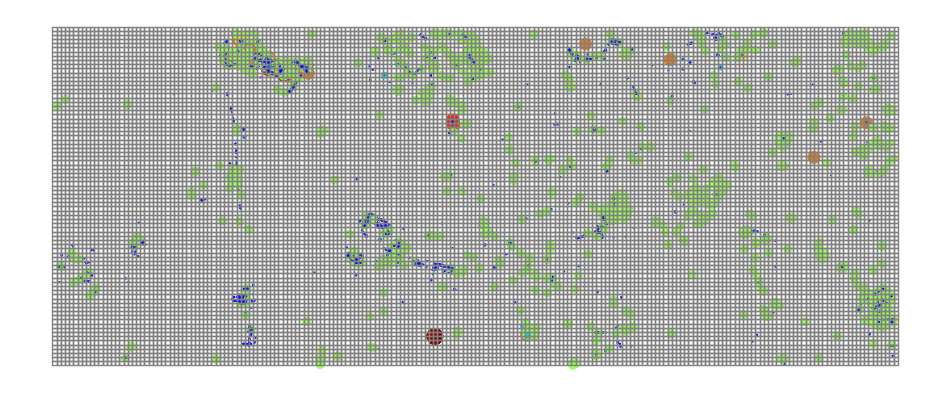

In [54]:
# plot the grid over the observations data
ax = aoi_obs_buff_gdf.plot(markersize=0.5, figsize=(12, 8), column='straal', cmap='jet')
# plt.autoscale(False)
grid_gdf.plot(ax=ax, facecolor="none", edgecolor='grey')
ax.axis("off");

### Calculate overlap

In [55]:
joined_aoi_gdf = gp.overlay(grid_gdf, aoi_obs_buff_gdf, how='union')
joined_aoi_gdf['area_joined'] = joined_aoi_gdf.area
joined_aoi_gdf.head(5)

/Users/robknapen/opt/mambaforge/envs/fairicube-pt2/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/robknapen/opt/mambaforge/envs/fairicube-pt2/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/robknapen/opt/mambaforge/envs/fairicube-pt2/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)


,cell_id,area_grid,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,area_buff,geometry,area_joined
0,4600.0,74460.110219,Bruin zandoogje,Maniola jurtina,2016.0,levend exemplaar,3.0,283.0,268814.60682,"POLYGON ((675234.913 5838811.263, 675234.913 5...",7086.206258
1,4800.0,74460.110219,Bruin zandoogje,Maniola jurtina,2016.0,levend exemplaar,3.0,283.0,268814.60682,"POLYGON ((675234.913 5838811.263, 675209.140 5...",837.108273
2,4401.0,74460.110219,Bruin zandoogje,Maniola jurtina,2016.0,levend exemplaar,3.0,283.0,268814.60682,"POLYGON ((675507.787 5838538.390, 675507.787 5...",19210.526595
3,4601.0,74460.110219,Bruin zandoogje,Maniola jurtina,2016.0,levend exemplaar,3.0,283.0,268814.60682,"POLYGON ((675234.913 5838811.263, 675507.787 5...",74006.086815
4,4801.0,74460.110219,Bruin zandoogje,Maniola jurtina,2016.0,levend exemplaar,3.0,283.0,268814.60682,"POLYGON ((675234.913 5838870.272, 675239.893 5...",45089.242922


In [56]:
# calculate the abundance proportions in each grid cell
joined_aoi_gdf['obs_share'] = (joined_aoi_gdf['area_joined'] / joined_aoi_gdf['area_buff'])
joined_aoi_gdf['abundance_share'] = (joined_aoi_gdf['obs_share'] * joined_aoi_gdf['orig_abundance'])
joined_aoi_gdf.head(5)

,cell_id,area_grid,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,area_buff,geometry,area_joined,obs_share,abundance_share
0,4600.0,74460.110219,Bruin zandoogje,Maniola jurtina,2016.0,levend exemplaar,3.0,283.0,268814.60682,"POLYGON ((675234.913 5838811.263, 675234.913 5...",7086.206258,0.026361,0.079083
1,4800.0,74460.110219,Bruin zandoogje,Maniola jurtina,2016.0,levend exemplaar,3.0,283.0,268814.60682,"POLYGON ((675234.913 5838811.263, 675209.140 5...",837.108273,0.003114,0.009342
2,4401.0,74460.110219,Bruin zandoogje,Maniola jurtina,2016.0,levend exemplaar,3.0,283.0,268814.60682,"POLYGON ((675507.787 5838538.390, 675507.787 5...",19210.526595,0.071464,0.214392
3,4601.0,74460.110219,Bruin zandoogje,Maniola jurtina,2016.0,levend exemplaar,3.0,283.0,268814.60682,"POLYGON ((675234.913 5838811.263, 675507.787 5...",74006.086815,0.275305,0.825916
4,4801.0,74460.110219,Bruin zandoogje,Maniola jurtina,2016.0,levend exemplaar,3.0,283.0,268814.60682,"POLYGON ((675234.913 5838870.272, 675239.893 5...",45089.242922,0.167734,0.503201


In [57]:
# save this data in a GIS format for reuse
joined_aoi_gdf.to_file(out_prefix + "aoi_cleaned_buffered_abundance_share.gpkg", driver="GPKG")

### Merge the observations with the grid
Merge the observations with the grid using a spatial join. Then use a simple count to aggregate the data.

In [58]:
merged_aoi_gdf = gp.sjoin(joined_aoi_gdf, grid_gdf, how='left', predicate='covered_by')
merged_aoi_gdf.head(5)

,cell_id_left,area_grid_left,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,area_buff,geometry,area_joined,obs_share,abundance_share,index_right,cell_id_right,area_grid_right
0,4600.0,74460.110219,Bruin zandoogje,Maniola jurtina,2016.0,levend exemplaar,3.0,283.0,268814.60682,"POLYGON ((675234.913 5838811.263, 675234.913 5...",7086.206258,0.026361,0.079083,23.0,4600.0,74460.110219
1,4800.0,74460.110219,Bruin zandoogje,Maniola jurtina,2016.0,levend exemplaar,3.0,283.0,268814.60682,"POLYGON ((675234.913 5838811.263, 675209.140 5...",837.108273,0.003114,0.009342,24.0,4800.0,74460.110219
2,4401.0,74460.110219,Bruin zandoogje,Maniola jurtina,2016.0,levend exemplaar,3.0,283.0,268814.60682,"POLYGON ((675507.787 5838538.390, 675507.787 5...",19210.526595,0.071464,0.214392,103.0,4401.0,74460.110219
3,4601.0,74460.110219,Bruin zandoogje,Maniola jurtina,2016.0,levend exemplaar,3.0,283.0,268814.60682,"POLYGON ((675234.913 5838811.263, 675507.787 5...",74006.086815,0.275305,0.825916,104.0,4601.0,74460.110219
4,4801.0,74460.110219,Bruin zandoogje,Maniola jurtina,2016.0,levend exemplaar,3.0,283.0,268814.60682,"POLYGON ((675234.913 5838870.272, 675239.893 5...",45089.242922,0.167734,0.503201,105.0,4801.0,74460.110219


In [59]:
# make a count column
merged_aoi_gdf['n_obs'] = 1

# aggregate the data
dissolve = merged_aoi_gdf.dissolve(by='index_right', aggfunc={ 'n_obs': 'count', 'abundance_share': 'sum'} )

# put the values into the grid
grid_gdf.loc[dissolve.index, 'abundance_share'] = dissolve['abundance_share'].values

/Users/robknapen/opt/mambaforge/envs/fairicube-pt2/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


<Axes: >

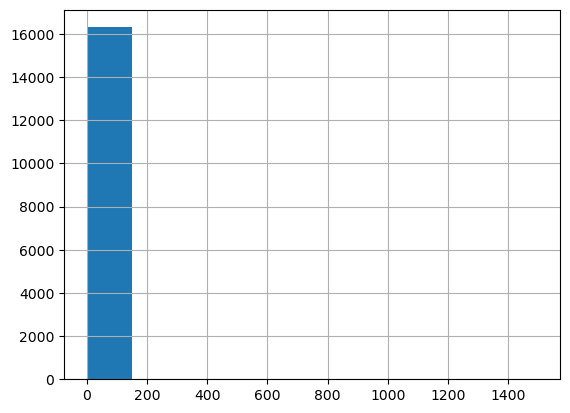

In [60]:
grid_gdf['abundance_share'].hist()

In [61]:
# select a proper vmax for map display (take it from the histogram)
vmax = 200

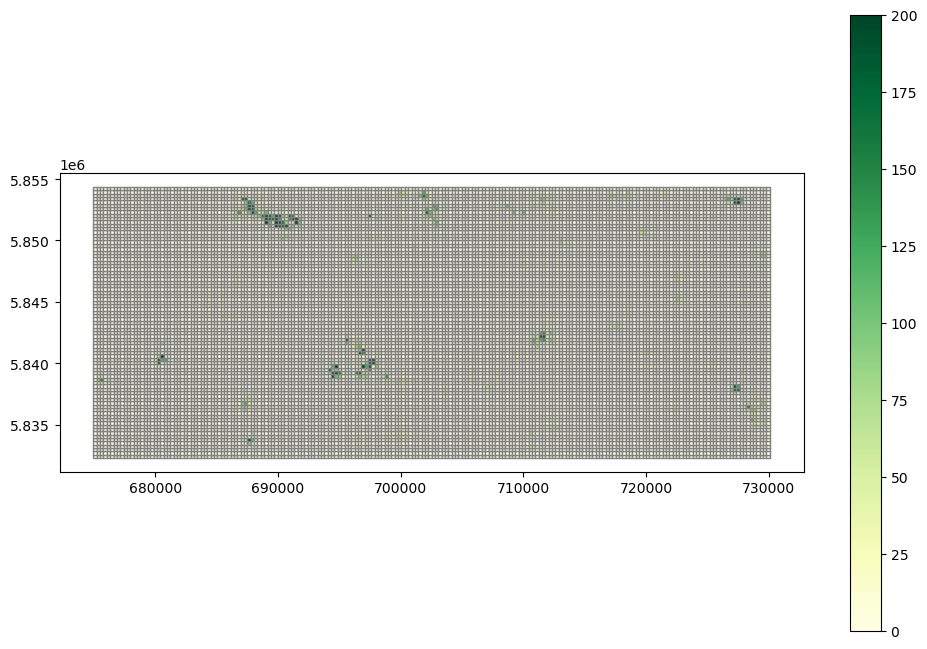

In [62]:
# plot the grid and the number of observations in each grid cell
grid_gdf.plot(
    column='abundance_share',
    figsize=(12, 8),
    cmap='YlGn',
    vmax=vmax,
    edgecolor='grey',
    legend=True
);

In [63]:
# run this cell to get an interactive map of the data (don't try for very small grid cells!)
#m1 = grid_gdf.explore(column='abundance_share', cmap='viridis', vmax=vmax, name='Count')
#m2 = aoi_obs_buff_gdf.explore(m=m1, color='red', name='Observations')
#m2

### Rasterize the grid cell polygons and write to GeoTIFF
One quick way to do this is with the [geocube](https://corteva.github.io/geocube/) package.

Note that this package can also perform some operations when rasterizing data, so in some cases it might be sufficient!

*TODO:*
  - *Fix the shifting of the grid cells (more noticeable with resolution).*
  - *Check how much gridding calculations can be done by geocube directly.*

In [67]:
# write the file (with CRS)
out_grid = make_geocube(
    vector_data=grid_gdf,
    measurements=['abundance_share'],
    resolution=(-cell_size, cell_size)
)
out_grid['abundance_share'].rio.to_raster(out_prefix + "aoi_cleaned_buffered_aggregated_abundance_share.tif")

### Extra: GeoPandas Spatial Index

Some interesting details about the R-Tree spatial index used can be found here:
 - [GeoPandas Spatial Index doc](https://geopandas.org/en/stable/docs/reference/sindex.html)
 - [PyGEOS STRTree doc](https://pygeos.readthedocs.io/en/latest/strtree.html)

In [65]:
# read-only access to the r-tree
r_tree = grid_gdf.sindex
r_tree.size

16362